## 🐎 Notebook 3.2: Building LLaMA 3.2 (1B and 3B Parameters) – A Reverse Journey!  

### 🌟 What’s Inside?  

1. **From Macro to Micro**:  
   - We'll **reverse-engineer the entire model** by starting with the high-level LLaMA 3.2 architecture, gradually breaking it down to its core components.  
   - This approach gives us a holistic understanding of large language models, focusing on **design choices and their impact on performance**.  

2. **Core LLaMA 3.2 Features**:  
   - **Grouped-Query Attention (GQA)** for efficient attention computation with key-value grouping.  
   - **RMSNorm** as a lightweight and effective normalization method.  
   - **Rotary Position Embeddings (RoPE)** with frequency scaling for efficient handling of extended context lengths.  

3. **Defining and Implementing LLaMA 3.2 Architecture**:  
   - We'll implement the **token embeddings**, **transformer stack**, and **feed-forward networks**, guided by the official configurations.  
   - Incorporate **RoPE frequency scaling** and **key-value groups** for grouped-query attention, enhancing efficiency.  

4. **Context Length and Scaling Innovations**:  
   - LLaMA 3.2 pushes boundaries with a **context length of 131,072 tokens**, making it well-suited for long-form text tasks.  
   - Explore how scaling context length and grouped attention influence performance and memory.  

5. **Running Inference on LLaMA 3.2 Models**:  
   - Test pre-trained weights for the 1B and 3B configurations, analyzing their performance on text generation tasks.  


### 🛠 **Architecture Recap (LLaMA 3.2 1B & 3B):**  

#### LLaMA 3.2 (1B):  
- **Vocabulary Size**: 128,256  
- **Context Length**: 131,072 tokens  
- **Embedding Dimension**: 2048  
- **Number of Attention Heads**: 32  
- **Number of Layers**: 16  
- **Feed-Forward Dimension**: 8192  
- **Grouped Key-Value Attention**: 8 groups  
- **RoPE Base**: 500,000  
- **Precision**: torch.bfloat16  

#### LLaMA 3.2 (3B):  
- **Vocabulary Size**: 128,256  
- **Context Length**: 131,072 tokens  
- **Embedding Dimension**: 3072  
- **Number of Attention Heads**: 24  
- **Number of Layers**: 28  
- **Feed-Forward Dimension**: 8192  
- **Grouped Key-Value Attention**: 8 groups  
- **RoPE Base**: 500,000  
- **Precision**: torch.bfloat16  

### **Summary of Main Architectural Differences Between GPT and LLaMA**

| **Aspect**               | **GPT**                                      | **LLaMA**                                   |
|---------------------------|----------------------------------------------|---------------------------------------------|
| **Activation Function**   | GELU (Gaussian Error Linear Unit)           | SiLU (Sigmoid Linear Unit)                 |
| **Normalization**         | LayerNorm                                   | RMSNorm (Root Mean Square Normalization)   |
| **Feedforward Network**   | Standard dense layers                       | Gated Linear Units (GLUs) for nonlinearity |
| **Attention Mechanism**   | Standard scaled dot-product attention       | Includes Rotary Embeddings for efficiency  |
| **Positional Encoding**   | Learned absolute positional embeddings      | Rotary positional embeddings               |

### **Key Takeaways**
- LLaMA's architectural tweaks, like RMSNorm and rotary embeddings, focus on efficiency while maintaining strong performance.
- GPT relies on more traditional design choices, such as LayerNorm and absolute positional embeddings, which have proven effective but may not be as efficient.


### 📚 **Goals for this Notebook:**  

1. **High-Level Architecture**:  
   - Start with the **entire model structure**, understanding how different components interact.  
   - Explore design principles like **GQA**, **RMSNorm**, and **RoPE scaling**.  

2. **Micro-Level Implementation**:  
   - Dive into each building block—token embeddings, transformer layers, feed-forward networks—and implement them following the LLaMA 3.2 specification.

3. **Implementing a custom tokenizer by extending the `tiktoken` library**:  
   - Extend the `tiktoken` library to support custom tokenization for LLaMA 3.2.  
   - This allows for custom tokenization for special characters and characters not present in the original tokenizer.
   

4. **Efficienct weight loading**:  
   - Load pre-trained weights for both configurations with memeory efficiency.



### **Why a Reverse Journey?**  

By building LLaMA 3.2 models from the top down, we aim to gain a new perspective on model design. This complements the bottom-up approach we used for GPT-2 and provides a unique opportunity to explore the scalability and efficiency of modern language models.  


### **Next Steps:**  

In this notebook, we embark on a journey to understand the design philosophy of **LLaMA 3.2** while implementing and testing its cutting-edge features. This will deepen our expertise in building and utilizing state-of-the-art large language models.  

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import tiktoken


### 🔍 **General Components in the `Llama3` Code**

The `Llama3` class comprises several key components that define the architecture of the LLaMA 3 model. Here's an overview:

1. **Token Embedding**:
   - Converts token indices into dense vector representations using `nn.Embedding`.
   - Represents the input sequence in a continuous embedding space.

2. **Transformer Blocks**:
   - A stack of transformer layers, implemented as `nn.Sequential`.
   - Each block includes mechanisms like grouped-query attention, feed-forward networks, and normalization.

3. **Final Normalization**:
   - Uses `RMSNorm` (Root Mean Square Normalization) to stabilize outputs from the transformer stack.

4. **Output Projection Layer**:
   - A linear layer that maps the hidden states back to the vocabulary size for token prediction.
   - Provides logits used to calculate probabilities over the vocabulary.

5. **Forward Pass Logic**:
   - Defines how input data flows through the model:
     - Embedding → Transformer Stack → Normalization → Output Projection.


### 📚 **Next Steps**

We'll dive into each of these components, starting with the **Transformer Blocks**, to explore how they contribute to the overall model functionality!
<p align="center">
    <img src="images/llama3.png" alt="My Image" />
</p>



In [2]:
class Llama3(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer to convert token indices into dense vector representations
        self.token_emedding = nn.Embedding(
            config['vocab_size'], config['emb_dim'], dtype=config['dtype']
        )
        # Stack of transformer blocks, forming the core of the model
        self.tras_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layers'])]
        )
        # Final RMSNorm layer to normalize outputs of the transformer stack
        self.final_norm = nn.RMSNorm(config['emb_dim'])
        # Linear layer to project the hidden states back to the vocabulary size
        self.output = nn.Linear(
            config['emb_dim'], config['vocab_size'], bias=False, dtype=config['dtype']
        )

    def forward(self, x):
        # Token embedding: Convert input token indices to dense embeddings
        tok_emb = self.token_emedding(x)
        x = tok_emb
        # Pass through the stack of transformer blocks
        x = self.tras_blocks(tok_emb)
        # Normalize the output of the transformer stack
        x = self.final_norm(x)
        # Project the normalized output to the vocabulary space and return logits
        logits = self.output(x.to(torch.bfloat16))
        return logits


### **📚 Understanding RMSNorm: Root Mean Square Normalization**

RMSNorm, or Root Mean Square Normalization, is a normalization technique introduced as a simplified alternative to Layer Normalization (LayerNorm). Unlike LayerNorm, which normalizes activations using their mean and variance, RMSNorm focuses solely on the root mean square (RMS) of the inputs.


### **🔍 Key Differences Between RMSNorm and LayerNorm**
| **Aspect**                | **LayerNorm**                                      | **RMSNorm**                                   |
|---------------------------|---------------------------------------------------|-----------------------------------------------|
| **Normalization**         | Centers data by subtracting the mean and scaling by variance. | Scales inputs based on their RMS only, without centering. |
| **Parameters**            | Learns both scale (gamma) and shift (beta).       | Learns only scale (gamma).                   |
| **Efficiency**            | Slightly more computational overhead due to mean computation. | Computationally simpler and faster.          |
| **Centering of Inputs**   | Always centers inputs (zero mean).                | Does not center inputs (focuses only on magnitude). |





### **✨ How RMSNorm Works**

Given an input vector \( x \in \mathbb{R}^d \):

1. **Compute the RMS of the input**:  
   \[
   \text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2}
   \]
   where \( d \) is the dimensionality of the input \( x \).

2. **Normalize the input by dividing each element by the RMS**:  
   \[
   \hat{x}_i = \frac{x_i}{\text{RMS}(x)}
   \]

3. **Scale the normalized input using a learned scale parameter \( \gamma \)**:  
   \[
   y_i = \gamma \cdot \hat{x}_i
   \]



Note: Unlike LayerNorm, RMSNorm omits the learned shift parameter \( \beta \), simplifying its implementation and making it more efficient.


### **🚀 Advantages of RMSNorm**
1. **Computational Efficiency**: Since it does not compute the mean, RMSNorm is faster and requires fewer operations than LayerNorm.
2. **Stability in Training**: It provides sufficient normalization for tasks like natural language processing (NLP) without needing centering.
3. **Alignment with LLaMA**: RMSNorm aligns well with the architectural design of LLaMA models, improving convergence in larger-scale settings.


### **🔧 Implementation Plan**
1. **Implement RMSNorm from Scratch**:
   - Calculate RMS manually.
   - Normalize and scale the input.
   - Validate the implementation with small inputs.

2. **Compare with PyTorch's Built-in RMSNorm**:
   - Use `torch.nn.RMSNorm` for comparison.
   - Match results for identical inputs.

3. **Analyze Performance**:
   - Measure speed and memory efficiency between custom and PyTorch implementations.



Let's start with the implementation of RMSNorm from scratch! 🚀

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, config, eps=1e-5):
        super().__init__()
        # Store the configuration and epsilon value for numerical stability
        self.config = config
        self.eps = eps
        
        # Initialize the scale parameter (gamma), which will be learned during training
        # It has the same shape as the embedding dimension (config['emb_dim'])
        self.scale = nn.Parameter(torch.ones(config['emb_dim']))  

    def forward(self, x):
        # Compute the mean squared value of the input tensor across the last dimension
        # This is used to calculate the RMS (Root Mean Square) of each element in the input
        mean = x.pow(2).mean(dim=-1, keepdim=True)  # mean(x^2) along the last dimension
        
        # Normalize the input by dividing each element by the RMS of that element
        # torch.rsqrt computes the inverse square root (1/sqrt(x))
        x_norm = x * torch.rsqrt(mean + self.eps)  # Normalize using RMS
        
        # Apply the learnable scale parameter (gamma) to the normalized tensor
        # This scale parameter allows the model to learn the optimal scaling factor
        output = (self.scale * x_norm).to(dtype=x.dtype)  # Ensure the output has the same dtype as the input
        
        # Return the scaled and normalized tensor
        return output


## **✨ Comparison with PyTorch's RMSNorm Implementation**

Now, let's compare our custom `RMSNorm` implementation with PyTorch's built-in `RMSNorm` (if available). We will check both outputs for a given input tensor.


In [4]:
# Define a sample configuration
config = {'emb_dim': 2048}

# Create a random input tensor
x = torch.randn(16, 32, config['emb_dim'])

# Create an instance of our custom RMSNorm
custom_rmsnorm = RMSNorm(config)
custom_output = custom_rmsnorm(x)

# Try PyTorch's RMSNorm implementation (if available)
try:
    from torch.nn import RMSNorm as TorchRMSNorm
    
    # Create an instance of PyTorch's RMSNorm
    torch_rmsnorm = TorchRMSNorm(config['emb_dim'], eps=1e-5)
    torch_output = torch_rmsnorm(x)
    
    # Compare the outputs (check if they are the same)
    outputs_are_equal = torch.allclose(custom_output, torch_output)
    print(f"Are the outputs equal? {outputs_are_equal}")
except ImportError:
    print("PyTorch RMSNorm is not available. Custom RMSNorm implementation is being used.")


Are the outputs equal? True


### **Transformer Block Overview**

The **Transformer Block** in the Llama model consists of the following key components:

1. **Masked Group-Query Attention with RoPE Scaling**:
   - **Masked Attention** ensures each token only attends to itself and previous tokens.
   - **Group-Query Attention** divides the query tensor into groups for more efficient computation.
   - **RoPE Scaling** encodes positional information of tokens to capture relative positions efficiently.

2. **Feedforward Network with SiLU Activation**:
   - A two-layer feedforward network with a **SiLU (Sigmoid Linear Unit)** activation function, adding non-linearity.

3. **RMSNorm**:
   - Applied twice: once after the attention layer and once after the feedforward layer, ensuring stable training and better performance.

This block processes the input data through attention, a feedforward network, and normalization, outputting the transformed sequence for further layers or the final output. We’ll implement and dive into each component separately.

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Initialize the multi-head attention layer
        self.att = GroupedQueryAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            num_kv_groups=config["n_kv_groups"],
            rope_base=config["rope_base"],
            rope_config=config["rope_freq"],
            dtype=config["dtype"]
        )
        # Initialize the feedforward layer
        self.ff = FeedForward(config)  # Assuming FeedForward is defined elsewhere
        # Initialize layer normalization layers
        self.norm1 = nn.RMSNorm(config['emb_dim'])  # First normalization layer
        self.norm2 = nn.RMSNorm(config['emb_dim'])  # Second normalization layer

    def forward(self, x):
        # Pass the input through the multi-head attention layer
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16))
        x = x + shortcut  # Residual connection
        
        # Pass the output through the feedforward layer
        shortcut = x  # Update shortcut after attention
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut  # Residual connection
        return x


### 1- **FeedForward Layer with SiLU Activation**

The **FeedForward layer** in a transformer block consists of two main components:

1. **Linear Transformation**: A fully connected layer that applies a linear transformation to the input tensor.
2. **Non-linear Activation**: After the linear transformation, a non-linear activation function is applied. In this case, we use **SiLU** (Sigmoid Linear Unit), which is a smooth and differentiable activation function that has shown strong performance in many deep learning models.

#### **SiLU Activation**:
SiLU, also known as the **Swish activation** function, is defined as:

\[
\text{SiLU}(x) = x \cdot \sigma(x)
\]

where \( \sigma(x) \) is the sigmoid function:

\[
\sigma(x) = \frac{1}{1 + e^{-x}}
\]

This activation is differentiable and allows for smooth gradients, making it particularly well-suited for deep networks.

#### **FeedForward Structure**:
The FeedForward layer typically follows this structure:

1. **First Linear Transformation**: A linear layer with a larger output dimension (often referred to as the "hidden dimension").
2. **SiLU Activation**: The SiLU activation is applied to the output of the first linear layer.
3. **Second Linear Transformation**: A linear layer that maps the output back to the original dimension.
4. **Dropout** (optional but often used): To prevent overfitting, dropout can be applied between the layers.

This layer is often followed by layer normalization and a residual connection to stabilize training and enable deeper architectures.

### **FeedForward Layer in Code**:

We'll implement this FeedForward layer with the SiLU activation. Let's go ahead and implement the `FeedForward` class using PyTorch.

In [6]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Initialize the first linear layer: Input -> Hidden layer
        self.fc1 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the second linear layer: Input -> Hidden layer (to be used in multiplication later)
        self.fc2 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the third linear layer: Hidden layer -> Output (back to original dimension)
        self.fc3 = nn.Linear(config['hidden_dim'], config['emb_dim'], bias=False)

    def forward(self, x):
        # Pass the input through the first linear layer
        x1 = self.fc1(x)
        
        # Pass the input through the second linear layer
        x2 = self.fc2(x)
        
        # Apply SiLU activation (Sigmoid Linear Unit) to the output of the first linear layer
        # Multiply the result with the output of the second linear layer
        # This operation introduces element-wise multiplication between activations and transformed values
        x = F.silu(x1) * x2 
        
        # Pass the result through the third linear layer to return to the original dimension
        x = self.fc3(x)
        
        return x


### **Comparison of Activation Functions: SiLU, ReLU, and GELU**

In this section, we'll compare three popular activation functions—**SiLU**, **ReLU**, and **GELU**—by plotting their behavior and understanding their differences.

---

### **SiLU Activation**

SiLU, or **Sigmoid Linear Unit**, is defined as:

\[
\text{SiLU}(x) = x \cdot \sigma(x)
\]

where \( \sigma(x) \) is the sigmoid function:

\[
\sigma(x) = \frac{1}{1 + e^{-x}}
\]

The SiLU function smoothly combines the input \( x \) with its sigmoid value, providing non-linearity while avoiding the sharp transition present in ReLU. This characteristic helps reduce issues such as vanishing gradients during training.

---

### **ReLU Activation**

ReLU (Rectified Linear Unit) is defined as:

\[
\text{ReLU}(x) = \max(0, x)
\]

It outputs the input directly for positive values, and zero for negative values. Although it is computationally efficient, ReLU can suffer from **dead neurons** when a large portion of the input is negative, which results in no gradient flow for these neurons.

---

### **GELU Activation**

GELU (Gaussian Error Linear Unit) is a probabilistic activation function, commonly used in Transformer-based models:

\[
\text{GELU}(x) = x \cdot \Phi(x)
\]

where \( \Phi(x) \) is the cumulative distribution function (CDF) of the standard normal distribution. GELU introduces a smoother non-linearity than ReLU and has become popular in modern deep learning architectures, particularly for its robustness and smoother gradient behavior.

---

### **Plotting the Activation Functions**

Now, let’s plot all three activation functions—SiLU, ReLU, and GELU—over a range of inputs from -5 to 5.




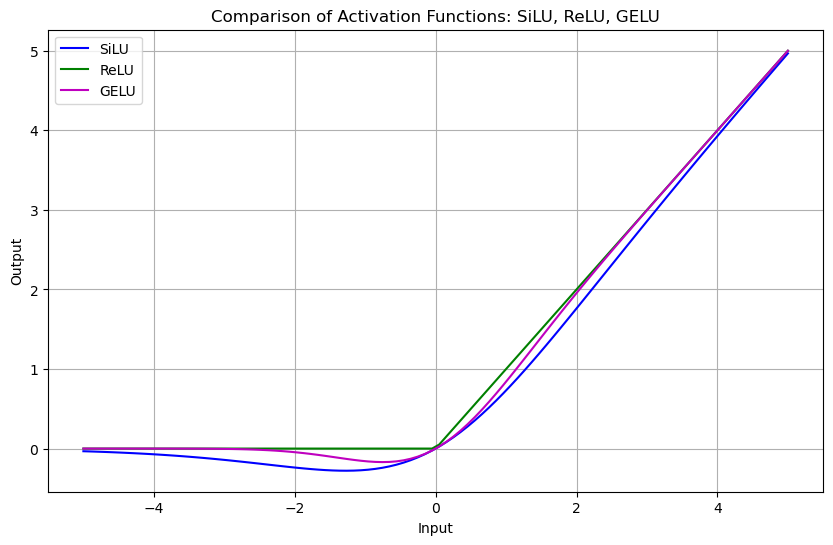

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create input tensor
x = torch.linspace(-5, 5, steps=100)

# SiLU implementation from scratch
def silu(x):
    return x * torch.sigmoid(x)

# Calculate activations
silu_output = silu(x)
relu_output = F.relu(x)
gelu_output = F.gelu(x)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), silu_output.numpy(), label='SiLU', color='b')
plt.plot(x.numpy(), relu_output.numpy(), label='ReLU', color='g')
plt.plot(x.numpy(), gelu_output.numpy(), label='GELU', color='m')
plt.title('Comparison of Activation Functions: SiLU, ReLU, GELU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

### **Results and Observations**

- **SiLU**: The output of SiLU is smooth and continuous. It does not cut off negative values entirely, instead producing a small non-zero output for negative inputs. This smoothness allows SiLU to provide a more gradual non-linearity compared to ReLU.
  
- **ReLU**: ReLU has a sharp transition at zero, mapping all negative inputs to zero. This can be beneficial for reducing computation time and handling sparse activations, but it can also lead to dead neurons, where neurons always output zero, stopping them from learning.

- **GELU**: GELU is also smooth but differs from SiLU in that it approximates a normal distribution. The curve for GELU is slightly smoother and more probabilistic, offering small non-zero outputs for negative inputs, making it well-suited for complex deep learning architectures like Transformers.


### **Summary**

- **SiLU** and **GELU** both offer smoother, more continuous activation curves compared to ReLU.
- **ReLU** is more computationally efficient but can suffer from dead neurons and less smooth gradients.
- **SiLU** provides a good balance between smoothness and computational efficiency.
- **GELU** is more sophisticated and can be more effective in certain deep models, such as Transformers, due to its probabilistic nature.

By comparing these activation functions, you can choose the most suitable one for your neural network model, depending on your specific requirements (e.g., computational efficiency vs. gradient smoothness).

### **2-Rotary Positional Embedding (RoPE) in Transformers**

Rotary Positional Embedding (RoPE) is a method for encoding the position of tokens in a sequence, designed to improve the effectiveness of positional encodings in transformer models. It is used to capture the relative position information between tokens, which is crucial for handling sequential data. RoPE is particularly useful in transformer architectures and has been shown to enhance the performance of models in tasks such as language modeling and machine translation.

---

### **Why RoPE?**

In traditional transformer models, positional encodings are added to the input embeddings to provide the model with information about the order of tokens in a sequence. The most common approach, **sinusoidal positional encoding**, uses fixed sinusoidal functions based on the position of the tokens.

However, RoPE introduces a more flexible and efficient method for encoding the relative position between tokens by rotating the embedding vectors. This approach offers the following benefits:

- **Scalability**: RoPE allows for better handling of long sequences, as it improves the ability of the transformer to generalize to longer sequences than those seen during training.
- **Flexibility**: It provides more flexibility in how position information is encoded, improving model performance on tasks where relative positioning is important.
- **Attention Masking**: RoPE works naturally with causal masking in autoregressive tasks, making it a good fit for language models.

<p align="center">
    <img src="images/rope.png" alt="My Image" />
</p>

## **Understanding RoPE (Rotary Positional Embedding)**

To fully grasp how **Rotary Positional Embedding (RoPE)** works and why it has become a key method in transformer-based models, it's essential to understand several foundational concepts:

### 1. **Relative vs Absolute Positioning**
   - **Absolute Positioning**: In traditional transformers, each token in the sequence is assigned a unique positional encoding that is added to the token's embedding. This method, called **absolute positional encoding**, directly encodes the position of a token in the sequence (e.g., the first token gets position 0, the second token gets position 1, and so on). The position of each token is independent of others.
   
   - **Relative Positioning**: In contrast, **relative positional encoding** focuses on the relative distance between tokens. The idea is that the meaning of a token depends not just on its position in the sequence, but on its relationship with other tokens. RoPE, in particular, uses **rotations** to capture this relative positional information, making it more adaptable and flexible for tasks involving variable-length sequences.

### 2. **Dot Product vs Inner Product**
   - Both **dot product** and **inner product** refer to mathematical operations that involve two vectors. However, they are often used interchangeably in the context of linear algebra and machine learning. 
     - The **dot product** of two vectors \( \mathbf{a} \) and \( \mathbf{b} \) is computed as:

       \[
       \mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i
       \]
       
       It results in a scalar value that can measure the similarity between two vectors.
     
     - The **inner product** is a more generalized form of the dot product, where the two vectors can be elements of a more general vector space (e.g., function spaces). In Euclidean space, the dot product is a special case of the inner product. The inner product measures how much one vector projects onto another.

   - RoPE makes use of the dot product (specifically, the query and key vectors in the attention mechanism) but applies rotations to these vectors to encode the relative positions between tokens. The use of rotations preserves the vector structure while enabling the transformer model to understand positional relationships.

### 3. **Rotation Matrix**
   - A **rotation matrix** is a special orthogonal matrix used to perform a rotation of vectors in Euclidean space. In 2D, a rotation matrix for an angle \( \theta \) is defined as:

     \[
    
     \begin{bmatrix}
     \cos(\theta) & -\sin(\theta) \\
     \sin(\theta) & \cos(\theta)
     \end{bmatrix}
     \]

   - In higher dimensions, rotation matrices generalize this idea. RoPE applies a rotation matrix to each position embedding, where the rotation angle is dependent on the position of the token in the sequence. This allows the model to capture **relative positional information** between tokens in a computationally efficient way.
   
   - Instead of adding fixed positional encodings, RoPE rotates the query and key vectors in the attention mechanism by different amounts depending on the token's position. This method provides a flexible way to encode positional relationships without requiring large and static matrices.

   *Note*: The general form of the equation is shown as follows:

   <p align="center">
       <img src="images/gn_rope.png" alt="Rotation Matrix Equation" />
   </p>

   If you notice, the matrix includes a large number of zero values (many values turn to zero), which is a waste of computational resources. A better solution is to implement a more efficient way, as shown below:

### 4. **RoPE as the Computationally Efficient Form**

<p align="center">
    <img src="images/eff_rope.png" alt="Efficient RoPE" />
</p>

RoPE offers a flexible, efficient, and scalable way to encode positional information in transformer models. Understanding key concepts such as **relative vs absolute positioning**, **dot product vs inner product**, and the **rotation matrix** are crucial for appreciating how RoPE works. Its computational efficiency stems from the fact that it encodes relative position information via rotations, avoiding the need for large positional embedding matrices and making it particularly effective for handling long sequences in NLP tasks.

## But How to Do This Math Stuff in PyTorch?

Remember, PyTorch is not just a deep learning framework, but also a powerful **computational library** that comes with a wide range of functionalities. These built-in operations can significantly simplify the math involved in tasks like **Rotary Positional Encoding (RoPE)**, making it easier to implement the complex mathematical concepts needed for transformers and attention mechanisms.

Let's explore how to implement key mathematical concepts in PyTorch for RoPE.



In [8]:
# Step 1: Define the sequence length and head dimension
# The sequence length represents the number of tokens (positions) in the sequence
# The head dimension represents the number of embedding dimensions for each token
sequence_length = 1024  # Length of the sequence (number of tokens)
head_dim = 64           # Dimension of each token's embedding vector
theta_base = 10000.0    # Base value used to calculate positional frequencies

# Step 2: Create the position tensor `m` representing the position of each token in the sequence
# `m` will have values from 0 to sequence_length - 1, representing the position of each token
# Mathematically, `m` is a vector {0, 1, 2, ..., sequence_length-1}
m = torch.arange(sequence_length).float()  # Positions in the sequence

# Step 3: Calculate the theta values using the formula from the Reformer paper
# We are calculating theta_i = 10000^(-2(i-1)/dim) for i = 1, 2, ..., head_dim/2
# The `theta_numerator` represents the indices i for every alternate value (i.e., 0, 2, 4, ..., head_dim-2)
theta_numerator = torch.arange(0, head_dim, 2).float()  # Indices for every alternate value
theta = 1.0 / (theta_base ** (theta_numerator / head_dim))  # Compute the theta values for each embedding dimension

# Step 4: Compute the outer product between `m` (positions) and `theta` (frequencies)
# The outer product between `m` and `theta` gives us a matrix where each element is the product of position and frequency
# Mathematically, freqs(i, j) = m_i * theta_j for each position i and dimension j
freqs = torch.outer(m, theta).float()  # Outer product between m and theta, resulting in positional frequencies

# Step 5: Convert the positional frequencies to complex numbers in polar form
# In polar form, a complex number is represented as R * exp(i * theta), where R = 1 (magnitude)
# We use `torch.polar` to create complex numbers with a magnitude of 1 and the computed frequencies as angles
freqs_complex = torch.polar(torch.ones_like(freqs), freqs)  # Convert frequencies to complex numbers (polar form)

# Now, `freqs_complex` contains the complex numbers representing the rotational encodings for each position
print(freqs_complex)

tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  0.7318+6.8156e-01j,  0.8460+5.3317e-01j,
          ...,  1.0000+2.3714e-04j,  1.0000+1.7783e-04j,
          1.0000+1.3335e-04j],
        [-0.4161+9.0930e-01j,  0.0709+9.9748e-01j,  0.4315+9.0213e-01j,
          ...,  1.0000+4.7427e-04j,  1.0000+3.5566e-04j,
          1.0000+2.6670e-04j],
        ...,
        [-0.9998+1.7612e-02j,  0.6164-7.8744e-01j, -0.7242+6.8960e-01j,
          ...,  0.9708+2.3976e-01j,  0.9836+1.8057e-01j,
          0.9907+1.3573e-01j],
        [-0.5550-8.3182e-01j,  0.9877-1.5612e-01j, -0.9803+1.9732e-01j,
          ...,  0.9708+2.3999e-01j,  0.9835+1.8074e-01j,
          0.9907+1.3586e-01j],
        [ 0.4001-9.1649e-01j,  0.8292+5.5900e-01j, -0.9346-3.5578e-01j,
          ...,  0.9707+2.4022e-01j,  0.9835+1.8092e-01j,
          0.9907+1.3600e-01j]])


In [9]:
# THIS IS A COMPACT IMPLEMENTATION OF THE SAME CELL ABOVE 
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    # As written in the paragraph 3.2.2 of the paper
    # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
    assert head_dim % 2 == 0, "Dimension must be divisible by 2"
    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device) # (Dim / 2)
    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex


### Applying Rotary Positional Encoding to Tokens

Now that we have computed the positional frequencies (`freqs_complex`), we need to apply these to the input tokens by following these steps:

#### Step 1: Group Every Two Tokens Side by Side

In this step, we take the original vector of tokens and reshape it such that every two consecutive tokens are grouped together side by side. For example:

- **Original:**
  ```
  x1
  x2
  x3
  x4
  ...
  ```

- **After Grouping:**
  ```
  x1  x2
  x3  x4
  ...
  ```

This operation is performed using tensor reshaping, where we group the tokens in the last dimension of the tensor:

```python
x = x.float().reshape(*x.shape[:-1], -1, 2)
```

#### Step 2: Convert `x` to Complex Numbers

After reshaping, we convert `x` into complex numbers. This allows us to perform operations with both real and imaginary components. The `torch.view_as_complex` function transforms the reshaped tensor into a complex tensor:

```python
x_complex = torch.view_as_complex(x)
```

#### Step 3: Match the Shape of `freqs_complex` with `x_complex`

Next, we need to adjust the shape of `freqs_complex` to match the shape of the manipulated input `x_complex`. Since `x_complex` has an additional dimension (representing the pairs of tokens), we need to add extra dimensions to `freqs_complex` so they align for multiplication.

```python
freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
```

This operation adds the necessary dimensions, ensuring that both `x_complex` and `freqs_complex` can be multiplied together element-wise in the next step.

#### Step 4: Multiply `x_complex` and `freqs_complex`

Now, we perform element-wise multiplication between `x_complex` and `freqs_complex` to apply the rotary positional encoding. This rotation operation is performed for each pair of tokens in the input:

```python
x_rotated = x_complex * freqs_complex
```

#### Step 5: Convert Back to Real Numbers and Reshape

Finally, we convert the result back to real numbers using `torch.view_as_real`, which separates the real and imaginary parts of the complex numbers. We then reshape the output tensor to match the input shape:

```python
x_out = torch.view_as_real(x_rotated)
x_out = x_out.reshape(*x.shape)
```

We return the output tensor, ensuring it has the same type and device as the input `x`:

```python
return x_out.type_as(x).to(device)
```

### Summary

- **Step 1**: Reshape `x` to group every two tokens side by side.
- **Step 2**: Convert the reshaped tokens to complex numbers.
- **Step 3**: Match the shape of `freqs_complex` to the manipulated `x`.
- **Step 4**: Perform element-wise multiplication between `x_complex` and `freqs_complex` to apply the rotary encoding.
- **Step 5**: Convert back to real numbers and reshape the output tensor to match the input dimensions.
```

In [10]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

Lets test it : 

In [11]:
# Example input
batch_size = 4
seq_len = 10
head_dim = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate random input tensor (batch_size, seq_len, num_heads, head_dim)
x = torch.randn(batch_size, seq_len, 8, head_dim, device=device)

# Precompute frequency complex numbers
freqs_complex = precompute_theta_pos_frequencies(head_dim, seq_len, device)

# Apply rotary position embeddings
x_rot = apply_rotary_embeddings(x, freqs_complex, device)

print("Input shape:", x.shape)
print("Rotated shape:", x_rot.shape)   
print(x_rot[:5]) 


Input shape: torch.Size([4, 10, 8, 16])
Rotated shape: torch.Size([4, 10, 8, 16])
tensor([[[[ 1.1577e+00,  1.3184e+00,  5.0834e-01,  ..., -9.7599e-01,
            1.1586e+00,  1.9374e+00],
          [-1.0720e+00, -5.4686e-01, -1.2111e-01,  ..., -5.0799e-01,
            1.3958e-01, -2.0146e+00],
          [-1.4590e+00, -1.6140e+00, -1.9291e-01,  ...,  1.5239e+00,
           -1.2854e+00, -1.2796e+00],
          ...,
          [ 1.2009e+00,  3.6370e-02, -2.0441e+00,  ..., -1.4779e-01,
            5.8014e-01,  6.5439e-03],
          [-3.2665e-02,  5.5108e-01,  2.9841e-01,  ...,  3.1203e-01,
           -2.4552e-01, -2.8379e+00],
          [ 2.2076e+00, -9.4494e-01,  6.8589e-01,  ...,  3.5363e-01,
            2.5038e+00, -1.2166e+00]],

         [[ 2.0133e-01, -2.6638e-01, -3.7434e-01,  ..., -9.0972e-01,
           -2.3336e+00, -2.0996e+00],
          [-9.3490e-01, -1.6563e-01,  3.5745e-01,  ..., -5.0746e-01,
            6.0015e-01, -8.6968e-01],
          [ 1.6836e+00,  2.7123e-01, -8.8838e

### Grouped Query Attention (GQA)

**Grouped Query Attention (GQA)** is a variation of the standard **Multi-Head Attention (MHA)** mechanism used in transformer models. Instead of having multiple attention heads (as in MHA), GQA organizes queries into a smaller number of **query groups**, while the keys and values are not grouped. This approach reduces computational complexity while retaining expressive power.

<p align="center">
    <img src="images/GQA.png" alt="Efficient RoPE" />
</p>

#### Key Components of GQA:

1. **Query Grouping**:
   - Queries are divided into groups, leading to fewer query computations compared to MHA.
   - Keys and values are not grouped, allowing them to attend to all input tokens.

2. **Efficiency**:
   - Reduces the memory and compute requirements of the attention mechanism compared to MHA.
   - Particularly advantageous for large models or when memory efficiency is critical.


#### Differences Between GQA and MHA:

| **Feature**              | **Multi-Head Attention (MHA)**                  | **Grouped Query Attention (GQA)**         |
|--------------------------|------------------------------------------------|-------------------------------------------|
| **Query Organization**    | Multiple independent attention heads           | Queries are grouped into fewer groups     |
| **Key & Value Behavior**  | Separate keys and values for each attention head| Shared keys and values across query groups|
| **Complexity**            | Higher due to multiple heads                   | Lower due to reduced number of query groups|
| **Use Case**              | Suitable for tasks requiring high expressiveness | Suitable for memory-efficient scenarios   |


#### Practical Implication:

While MHA excels in providing diverse attention mechanisms across multiple heads, GQA trades off some of this flexibility to improve efficiency. It is commonly used in modern large-scale transformer architectures, like the **LLaMA** series, where scaling efficiency is critical without significantly compromising performance.

In [31]:
class SharedBuffers:
    # Dictionary to store precomputed buffers
    _buffers = {}

    @staticmethod
    def get_buffers(context_length, head_dim, rope_base, freq_config, dtype=torch.float32, device="cpu"):
        
        # Unique key based on the provided parameters to identify buffer configurations
        key = (
            context_length,
            head_dim,
            rope_base,
            tuple(freq_config.values()) if freq_config else freq_config,
            dtype
        )

        # Check if the buffers for this configuration already exist
        if key not in SharedBuffers._buffers:
            # If not, create the buffers

            # 1. Create a causal mask (upper triangular matrix)
            # Ensures future tokens do not attend to past tokens in the sequence
            mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)

            # 2. Compute RoPE frequencies using a custom precompute function
            # This function is assumed to generate complex frequencies for positional encoding
            freqs_complex = precompute_theta_pos_frequencies(
                head_dim, context_length, device, rope_base
            )

            # 3. Convert the RoPE frequencies to the desired data type if specified
            if dtype is not None:
                freqs_complex = freqs_complex.to(dtype)

            # 4. Cache the mask and frequencies in the shared dictionary
            SharedBuffers._buffers[key] = (mask, freqs_complex)

        # Return the cached or newly created buffers
        return SharedBuffers._buffers[key]


### **SharedBuffers Class**

The `SharedBuffers` class optimizes the efficiency of transformer models by precomputing and sharing reusable resources like causal masks and rotary position encoding frequencies. This avoids redundant computations and saves memory when processing sequences of different configurations.

### **Why Implement This?**
- **Improves Performance:** Precomputes frequently used tensors like causal masks and RoPE frequencies to avoid repeated calculations.
- **Saves Memory:** Stores shared resources in a centralized cache, preventing duplication.
- **Handles Multiple Configurations:** Manages buffers for varying sequence lengths, head dimensions, and positional encoding settings.

### **Benefits**
1. **Speed:** Precomputes and caches buffers for quick reuse.
2. **Flexibility:** Supports varying configurations without conflicts.
3. **Scalability:** Ideal for large transformer models like GPT variants.

This approach streamlines the transformer pipeline by efficiently managing shared resources.

In [ ]:
class GroupedQueryAttention(nn.Module):
    
    def __init__(
            self, d_in, d_out, context_length, num_heads,
            num_kv_groups, rope_base=10_000, rope_config=None,
            dtype=None, device='cpu'
        ):
        super().__init__()
        
        # Validations for divisibility constraints
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        # Initialization of key attributes
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Dimension per head
        self.device = device  # Store device for tensor operations

        # Linear transformations for keys, values, and queries
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)

        # Output projection layer for combining attention results
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)

        # Number of heads per group
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        # Fetch shared buffers for causal masks and RoPE frequencies
        mask, freqs_complex = SharedBuffers.get_buffers(
            context_length, self.head_dim, rope_base, rope_config, dtype=dtype, device=device
        )
        self.register_buffer("mask", mask)  # Cache causal mask as a buffer
        self.register_buffer("freqs_complex", freqs_complex)  # Cache RoPE frequencies as a buffer

    def forward(self, x):
        # x: Input tensor of shape (batch_size, num_tokens, d_in)
        b, num_tokens, d_in = x.shape

        # Compute keys, values, and queries
        queries = self.W_query(x)  # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)

        # Reshape keys, values, and queries for attention heads
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)

        # Transpose for compatibility with attention computation
        keys = keys.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        values = values.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        queries = queries.transpose(1, 2)  # Shape: (b, num_heads, num_tokens, head_dim)

        # Apply rotary position encoding (RoPE) to keys and queries
        keys = apply_rotary_embeddings(keys, self.freqs_complex, self.device)
        queries = apply_rotary_embeddings(queries, self.freqs_complex, self.device)

        # Expand keys and values to match the number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        values = values.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)

        # Compute scaled dot-product attention with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (b, num_heads, num_tokens, num_tokens)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Adjust mask size to current input length
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Apply causal mask

        # Normalize scores with softmax
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)  # Shape: (b, num_heads, num_tokens, num_tokens)

        # Compute attention output
        context_vec = (attn_weights @ values).transpose(1, 2)  # Shape: (b, num_tokens, num_heads, head_dim)

        # Combine attention heads into final output shape
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # Apply optional projection

        return context_vec


## The Configration of Llama 3.2 for : 
# 1- 1B Patameters 
# 2- 3B Parametrs

In [ ]:
# Llama 3.2 1B

LLAMA32_CONFIG = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # Context length
    "emb_dim": 2048,            # Embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 16,             # Number of layers
    "hidden_dim": 8192,         # Size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
    "rope_freq": {              # RoPE frequency scaling
        "factor": 32.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

# Llama 3.2 3B

# LLAMA32_CONFIG = {
#     "vocab_size": 128_256,      # Vocabulary size
#     "context_length": 131_072,  # Context length
#     "emb_dim": 3072,            # Embedding dimension
#     "n_heads": 24,              # Number of attention heads
#     "n_layers": 28,             # Number of layers
#     "hidden_dim": 8192,         # Size of the intermediate dimension in FeedForward
#     "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
#     "rope_base": 500_000.0,     # The base in RoPE's "theta"
#     "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
#     "rope_freq": {              # RoPE frequency scaling
#         "factor": 32.0,
#         "low_freq_factor": 1.0,
#         "high_freq_factor": 4.0,
#         "original_context_length": 8192,
#     }
# }

LLAMA_SIZE_STR = "1B" if LLAMA32_CONFIG["emb_dim"] == 2048 else "3B"

Reduce the context length so the model would work fine  (if you have more RAM, feel free to comment out the lines below):

In [15]:
old_context_length = LLAMA32_CONFIG["context_length"]
LLAMA32_CONFIG["context_length"] = 8192


def rescale_theta(theta_old, context_length_old, context_length_new):
    scaling_factor = context_length_new / context_length_old
    theta_new = theta_old * scaling_factor
    return theta_new

LLAMA32_CONFIG["rope_base"] = rescale_theta(
    LLAMA32_CONFIG["rope_base"],
    old_context_length,
    LLAMA32_CONFIG["context_length"]
)

print("New RoPE theta:", LLAMA32_CONFIG["rope_base"])

New RoPE theta: 31250.0


## Here a compact implemntaion of Llama 3.2 

In [32]:
# Llama3.py

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# FeedForward Class
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Initialize the first linear layer: projects input embedding to hidden dimension
        self.fc1 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the second linear layer: creates additional projections for gating mechanism
        self.fc2 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the third linear layer: maps back from hidden dimension to original embedding dimension
        self.fc3 = nn.Linear(config['hidden_dim'], config['emb_dim'], bias=False)

    def forward(self, x):
        # Compute first projection
        x1 = self.fc1(x)
        # Compute second projection for gating
        x2 = self.fc2(x)
        # Element-wise multiplication after SiLU activation introduces non-linear interactions
        x = F.silu(x1) * x2 
        # Project back to the original embedding space
        x = self.fc3(x)
        return x


# GroupedQueryAttention Class
class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, context_length, num_heads,
            num_kv_groups, rope_base=10_000, rope_config=None,
            dtype=None, device='cpu'  # Device is specified with a default value
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        # Initialize essential parameters
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.device = device

        # Define linear layers for keys, values, and queries
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        
        # Final projection layer after attention
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)

        # Configure the grouping structure for keys and values
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        # Shared buffers for causal mask and rotary embeddings
        mask, freqs_complex = SharedBuffers.get_buffers(
            context_length, self.head_dim, rope_base, rope_config, dtype=dtype, device=device
        )
        self.register_buffer("mask", mask)
        self.register_buffer("freqs_complex", freqs_complex)

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Compute queries, keys, and values
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # Reshape to support multi-head processing
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)

        # Transpose for compatibility with attention computation
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # Apply rotary embeddings for positional information
        keys = apply_rotary_embeddings(keys, self.freqs_complex, self.device)
        queries = apply_rotary_embeddings(queries, self.freqs_complex, self.device)

        # Expand keys and values to align with query groups
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Compute attention scores and apply causal mask
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Normalize attention scores and compute weighted sum of values
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads and apply final projection
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec


# TransformerBlock Class
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Initialize multi-head attention layer
        self.att = GroupedQueryAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            num_kv_groups=config["n_kv_groups"],
            rope_base=config["rope_base"],
            rope_config=config["rope_freq"],
            dtype=config["dtype"]
        )
        
        # Initialize feedforward network
        self.ff = FeedForward(config)
        
        # Layer normalization layers
        self.norm1 = nn.RMSNorm(config['emb_dim'])
        self.norm2 = nn.RMSNorm(config['emb_dim'])

    def forward(self, x):
        # Apply attention with residual connection
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16))
        x = x + shortcut
        
        # Apply feedforward network with residual connection
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut
        return x


# Llama3 Class
class Llama3(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Token embedding layer to transform input tokens to dense vectors
        self.token_embedding = nn.Embedding(
            config['vocab_size'], config['emb_dim'], dtype=config['dtype']
        )
        
        # Stack of transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layers'])]
        )
        
        # Final layer normalization
        self.final_norm = nn.RMSNorm(config['emb_dim'])
        
        # Output projection to vocabulary size
        self.out_head = nn.Linear(
            config['emb_dim'], config['vocab_size'], bias=False, dtype=config['dtype']
        )

    def forward(self, x):
        # Convert token indices to embeddings
        tok_emb = self.token_embedding(x)
        x = tok_emb
        
        # Pass through transformer layers
        x = self.trf_blocks(tok_emb)
        
        # Normalize and project to logits
        x = self.final_norm(x)
        logits = self.out_head(x.to(torch.bfloat16))
        return logits


In [17]:
print(LLAMA32_CONFIG)
model = Llama3(LLAMA32_CONFIG)
print(model)


{'vocab_size': 128256, 'context_length': 8192, 'emb_dim': 2048, 'n_heads': 32, 'n_layers': 16, 'hidden_dim': 8192, 'n_kv_groups': 8, 'rope_base': 31250.0, 'dtype': torch.bfloat16, 'rope_freq': {'factor': 32.0, 'low_freq_factor': 1.0, 'high_freq_factor': 4.0, 'original_context_length': 8192}}


C:\Users\user\AppData\Local\Temp\ipykernel_13560\1194935297.py:16: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:305.)
  freqs_complex = freqs_complex.to(dtype)


Llama3(
  (token_emedding): Embedding(128256, 2048)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_key): Linear(in_features=2048, out_features=512, bias=False)
        (W_value): Linear(in_features=2048, out_features=512, bias=False)
        (W_query): Linear(in_features=2048, out_features=2048, bias=False)
        (out_proj): Linear(in_features=2048, out_features=2048, bias=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=2048, out_features=8192, bias=False)
        (fc2): Linear(in_features=2048, out_features=8192, bias=False)
        (fc3): Linear(in_features=8192, out_features=2048, bias=False)
      )
      (norm1): RMSNorm((2048,), eps=None, elementwise_affine=True)
      (norm2): RMSNorm((2048,), eps=None, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_key): Linear(in_features=2048, out_features=512, bias=False)
        (W_value): Linear(in_fe

## Effiect methods for Mmemory saving : 
1- Lets verify that shared buffer class is working proplerly and there is no wasted or redundant computaion

In [18]:
print(model.trf_blocks[0].att.mask is model.trf_blocks[-1].att.mask)
print(model.trf_blocks[0].att.freqs_complex is model.trf_blocks[-1].att.freqs_complex)



True
True


2- Lets check the total number of the unique parametrs with the rescpect of the whole parametrs (will we use this info later)

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.token_emedding.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 1,498,482,688

Total number of unique parameters: 1,235,814,400


3- the effect of torch.bfloat16 compared to torch.float32 , as you will see the diifrence is huge 

In [20]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 11.42 GB
bfloat16: 5.71 GB


In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

In [34]:
# Importing necessary libraries
import os
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    def __init__(self, model_path):
        # Ensure that the provided model path is a valid file
        assert os.path.isfile(model_path), f"Model file {model_path} not found"
        
        # Load the mergeable ranks (Byte Pair Encoding) specific to the model
        mergeable_ranks = load_tiktoken_bpe(model_path)

        # Define special tokens for LLaMA3
        # These tokens help manage text boundaries, reserved spaces, and other control features in the text generation process
        self.special_tokens = {
            "<|begin_of_text|>": 128000,  # Token to signify the beginning of the text
            "<|end_of_text|>": 128001,    # Token to signify the end of the text
            "<|start_header_id|>": 128006,  # Token for starting a header section
            "<|end_header_id|>": 128007,   # Token for ending a header section
            "<|eot_id|>": 128009,         # Token for end-of-text (e.g., indicating the end of a content block)
        }
        
        # Additional reserved tokens for model-specific functionality (e.g., controlling certain operations)
        self.special_tokens.update({
            f"<|reserved_{i}|>": 128002 + i for i in range(256) if (128002 + i) not in self.special_tokens.values()
        })

        # Define the tokenization pattern
        # This regular expression is more complex compared to GPT-2 and captures more varied tokenization patterns
        # Handles contractions, special characters, and complex text formats like headers or sequences
        self.model = tiktoken.Encoding(
            name=Path(model_path).name,  # Use the name of the model file as the encoding name
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",  # Regex pattern for tokenization
            mergeable_ranks=mergeable_ranks,  # Load the BPE mergeable ranks specific to the model
            special_tokens=self.special_tokens  # Include special tokens defined earlier
        )


    def encode(self, text, bos=False, eos=False, allowed_special=set(), disallowed_special=()):
        """
        Encodes a given text input into tokens, optionally including special tokens like bos (beginning of sequence)
        and eos (end of sequence). The `allowed_special` and `disallowed_special` parameters allow for fine control 
        over which special tokens are included.
        """
        
        tokens = []

        # Optionally add the <|begin_of_text|> token if 'bos' is True (indicating the start of the sequence)
        if bos:
            tokens = [self.special_tokens["<|begin_of_text|>"]]

        # Use the tokenizer's `encode` method to tokenize the input text
        tokens += self.model.encode(text, allowed_special=allowed_special, disallowed_special=disallowed_special)

        # Optionally add the <|end_of_text|> token if 'eos' is True (indicating the end of the sequence)
        if eos:
            tokens.append(self.special_tokens["<|end_of_text|>"])

        return tokens

    def decode(self, tokens):
        """
        Decodes a sequence of tokens back into the original text.
        """
        return self.model.decode(tokens)


# Custom tiktoken for Llam 3.2

When comparing the tokenizer used in **LLaMA3** to that in **GPT-2**, there are several notable differences in how they handle tokenization and special token management. Here’s a breakdown of why these customizations are specific to **LLaMA3**:

# 1. **Special Tokens Handling**

In **GPT-2**, tokenization with `tiktoken` primarily involves using basic special tokens like `bos` (beginning of sequence) and `eos` (end of sequence). However, in **LLaMA3**, the tokenizer introduces custom special tokens:

- **Custom Special Tokens**:
  - `<|begin_of_text|>`: Marks the beginning of the sequence.
  - `<|end_of_text|>`: Marks the end of the sequence.
  - `<|start_header_id|>` and `<|end_header_id|>`: Used for identifying sections or headers within documents.
  - `<|eot_id|>`: A special end-of-text token.
  - **Reserved Tokens**: A series of reserved tokens (e.g., `<|reserved_0|>`, `<|reserved_1|>`, etc.) for managing model-specific operations.
  
These tokens help manage text boundaries and reserved spaces within the sequence, allowing for more controlled text generation. **GPT-2** didn’t need these since its primary concern was managing simple `bos` and `eos` tokens.

# 2. **Custom Tokenization Pattern**

The `pat_str` (regular expression) used in **LLaMA3** is more complex and nuanced compared to **GPT-2**:

- **Complex Pattern**:
  - The regex pattern in **LLaMA3** accounts for a wider variety of tokens, including contractions like `'s`, `'t`, `'ve`, etc., non-word characters, and specific sequences (e.g., `\p{L}` for letters, `\p{N}` for numbers).
  - This complex pattern is designed to capture tokenization nuances needed by **LLaMA3** for diverse, complex text inputs that might not adhere to standardized text structures. It ensures proper tokenization across a broader set of inputs.
  
  **GPT-2**, on the other hand, used a simpler pattern that assumed more standardized text data.

# 3. **Model-Specific Token Mergeable Ranks (BPE)**

- In **LLaMA3**, a custom BPE (Byte Pair Encoding) mergeable rank table is loaded from the model path using `load_tiktoken_bpe(model_path)`.
- This customization reflects **LLaMA3**’s unique tokenization scheme, which might be trained to handle specific token merging requirements, vocabulary specifics, and other model-specific data.
- **GPT-2** used a standard BPE rank table, as its training data was more general and less model-specific.

# 4. **Configurable Special Token Behavior in Encoding**

- **LLaMA3**’s `encode` method allows for fine-grained control over special tokens:
  - `bos` (beginning-of-sequence): Optionally include `<|begin_of_text|>` at the start of a sequence.
  - `eos` (end-of-sequence): Optionally append `<|end_of_text|>` at the end.
  - `allowed_special` and `disallowed_special`: These parameters allow the user to control which special tokens can or cannot be used during encoding. This feature is particularly useful when fine-tuning the model for specific tasks or generating text with constraints.
- **GPT-2** didn’t offer this level of flexibility; its configuration was more rigid and predefined, focusing only on basic `bos` and `eos` tokens.

# Why These Additions for LLaMA3?

These customizations in **LLaMA3**'s tokenizer reflect its more **complex text processing requirements**:

1. **Greater control over text boundaries**: With tokens like `<|start_header_id|>` and `<|end_header_id|>`, **LLaMA3** can manage sections or headers within documents, which is crucial for structured data or document-level tasks.
2. **Advanced tokenization flexibility**: The complex `pat_str`, configurable token behavior, and customized BPE patterns in **LLaMA3** allow for nuanced handling of text inputs, enabling tasks like document processing, complex text generation, and preserving context throughout the input sequence.
3. **Fine-grained management of special tokens**: The ability to define `allowed_special` and `disallowed_special` tokens allows **LLaMA3** to manage sequences more precisely, especially during inference and fine-tuning.
4. **Model-Specific Training Requirements**: The customizations in **LLaMA3**’s tokenizer are tailored to fit its training data and architecture. This includes a need for specific token merge behaviors, vocabulary coverage, and how tokens are processed during tokenization.

In summary, the tokenizer used in **LLaMA3** has been customized to handle complex text processing needs like managing sections, headers, complex token merging, and flexible token behavior. These additions make **LLaMA3** more flexible and capable in handling a diverse set of text tasks compared to **GPT-2**.

## Loading the open weights using Hugging Face

<p align="center">
    <img src="images/gf1.png" alt="Efficient RoPE" />
</p>

<p align="center">
    <img src="images/gf2.png" alt="Efficient RoPE" />
</p>

<p align="center">
    <img src="images/gf3.png" alt="Efficient RoPE" />
</p>

<p align="center">
    <img src="images/gf4.png" alt="Efficient RoPE" />
</p>

<p align="center">
    <img src="images/gf5.png" alt="Efficient RoPE" />
</p>

In [ ]:
# Make sure you have an account to generate access token 
# make sure t have the right premission to access the repo from huggingface
from huggingface_hub import login

login()

In [24]:
from huggingface_hub import hf_hub_download
LLAMA_SIZE_STR = "1B" if LLAMA32_CONFIG["emb_dim"] == 2048 else "3B"


tokenizer_file_path = hf_hub_download(
    repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",
    filename="original/tokenizer.model",
    local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"
)

In [33]:
tokenizer = Tokenizer(tokenizer_file_path)

print(tokenizer.model.encode("Hello, how are you?"))

[9906, 11, 1268, 527, 499, 30]


### Purpose of the `assign` and `load_weights_into_llama` Functions

The `assign` function is responsible for verifying the shape consistency between two tensors and then copying the data from one tensor (right) to another (left). If the `right` tensor is a PyTorch tensor, it is cloned and detached before being returned as a `torch.nn.Parameter`. If not, a tensor is created from the data and returned as a `torch.nn.Parameter`.

The `load_weights_into_llama` function uses the `assign` function to load pre-trained weights into the LLaMA model. It ensures that the model's weights are correctly initialized from a given `params` dictionary. The function handles multiple layers, including the token embedding layer, attention layers, feed-forward layers, normalization layers, and the output layer. It also checks for weight tying between the embedding and output layers.

Together, these functions facilitate loading and validating the weights of a model, ensuring that the parameters align correctly, which is critical for the model to perform well.



In [ ]:
def assign(left, right, tensor_name="unknown"):
    # Ensure that the shapes of the tensors are the same
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}")

    # If 'right' is already a tensor, clone and detach it to avoid modifying the original tensor
    if isinstance(right, torch.Tensor):
        return torch.nn.Parameter(right.clone().detach())
    else:
        # If 'right' is not a tensor, create a new tensor and return it as a Parameter
        return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_llama(model, param_config, params):
    # Load the token embedding weight from the 'params' dictionary into the model
    model.token_emedding.weight = assign(model.token_emedding.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")

    # Loop through each layer in the model and load the corresponding weights
    for l in range(param_config["n_layers"]):

        # Load attention weights for the current layer
        model.trf_blocks[l].att.W_query.weight = assign(
            model.trf_blocks[l].att.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight"
        )
        model.trf_blocks[l].att.W_key.weight = assign(
            model.trf_blocks[l].att.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight"
        )
        model.trf_blocks[l].att.W_value.weight = assign(
            model.trf_blocks[l].att.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight"
        )
        model.trf_blocks[l].att.out_proj.weight = assign(
            model.trf_blocks[l].att.out_proj.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight"
        )
        model.trf_blocks[l].norm1.weight = assign(
            model.trf_blocks[l].norm1.weight,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight"
        )

        # Load FeedForward network weights for the current layer
        model.trf_blocks[l].ff.fc1.weight = assign(
            model.trf_blocks[l].ff.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"],
            f"model.layers.{l}.mlp.gate_proj.weight"
        )
        model.trf_blocks[l].ff.fc2.weight = assign(
            model.trf_blocks[l].ff.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"],
            f"model.layers.{l}.mlp.up_proj.weight"
        )
        model.trf_blocks[l].ff.fc3.weight = assign(
            model.trf_blocks[l].ff.fc3.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"],
            f"model.layers.{l}.mlp.down_proj.weight"
        )
        model.trf_blocks[l].norm2.weight = assign(
            model.trf_blocks[l].norm2.weight,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight"
        )

    # Load the final normalization layer weights
    model.final_norm.weight = assign(model.final_norm.weight, params["model.norm.weight"], "model.norm.weight")

    # If the model has a language model head weight, load it
    if "lm_head.weight" in params.keys():
        model.out_head.weight = assign(model.out_head.weight, params["lm_head.weight"], "lm_head.weight")
    else:
        # If no language model head weight exists, tie the embedding and output head weights
        model.out_head.weight = assign(model.out_head.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")
        print("Model uses weight tying.")


# Sequential Model Weight Loading in Neural Networks

When working with large-scale pre-trained models, the size of the model's weight files can become a bottleneck for downloading, loading, and memory management. Sequential model weight loading is a strategy designed to handle such challenges efficiently. Here's a breakdown of the concept and its implementation:

## Concept of Sequential Model Weight Loading

### Purpose:
Sequential model weight loading allows for:
- **Efficient handling of large model weights**: Breaking large weight files into smaller parts reduces memory pressure during download and loading.
- **Scalability**: Supports models of varying sizes, from smaller configurations to massive models that require splitting.
- **Flexibility**: Enables selective loading or merging of weights based on storage formats and requirements.

### How It Works:
1. **Small Models**: If the model weights fit into a single file, the weights can be directly loaded into memory.
2. **Large Models**: 
   - The weight files are split into smaller chunks, such as `model-00001-of-00002`, `model-00002-of-00002`, etc.
   - These parts are loaded sequentially, and their contents are combined into a unified dictionary.
   - Once all parts are merged, the combined weights are loaded into the model.

### Benefits:
- **Memory Optimization**: Downloads and processes smaller chunks rather than loading everything into memory at once.
- **Ease of Distribution**: Makes it easier to share and store large model files by dividing them into smaller parts.
- **Consistency**: The model is loaded with all weights in a unified manner after combination.

## Example Implementation
The following demonstrates sequential weight loading:
This script handles the loading of pre-trained weights for the LLaMA model, using the SafeTensors format, which is efficient and safe for model storage. The logic adjusts depending on the model size, either downloading a single file for smaller models or multiple files for larger ones, combining them as needed before loading the weights into the model.

In [ ]:
from safetensors.torch import load_file  # Import the function to load weights in the SafeTensors format.

# Check the size of the model being used
if LLAMA_SIZE_STR == "1B":
    # If the model is 1 billion parameters, download a single weights file
    weights_file = hf_hub_download(
        repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",  # Repository name on Hugging Face hub
        filename=f"model.safetensors",                              # Single file for smaller models
        local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"            # Directory to store downloaded weights
    )
    combined_weights = load_file(weights_file)  # Load the weights into memory.

else:
    # For larger models, weights are split across multiple files. Combine them.
    combined_weights = {}
    for i in range(1, 3):  # Assuming weights are split into two parts.
        weights_file = hf_hub_download(
            repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",  # Repository name on Hugging Face hub
            filename=f"model-0000{i}-of-00002.safetensors",             # Access each part by index
            local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"            # Directory to store downloaded weights
        )
        current_weights = load_file(weights_file)  # Load the current part of the weights.
        combined_weights.update(current_weights)   # Merge the current part into the combined weights.

# Load the combined weights into the LLaMA model
load_weights_into_llama(model, LLAMA32_CONFIG, combined_weights)

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Free up memory by deleting the combined weights after loading them into the model
del combined_weights


Model uses weight tying.


# 🐎 Summary of  Notebook 3.2: Building LLaMA 3.2 (1B and 3B Parameters) – A Reverse Journey!  

🎉 **Congratulations on completing this notebook!** Here's a recap of what we achieved:  


## **What We Did**  

### **From GPT-2 to LLaMA 3.2**  
We started with a strong foundation by building GPT-2, and then took a step up to construct LLaMA 3.2 models with **1B** and **3B parameters**.  
- **Key Differentiation**: We highlighted the architectural differences between GPT-2 and LLaMA models.  
- **Reverse (Top-Down) Approach**: By taking a top-down perspective, we gained new insights into building transformers from the big picture to the fine details.  


### **Customized Tokenizer**  
To suit LLaMA’s needs, we extended the capabilities of the `tiktoken` tokenizer, showcasing how custom solutions can enhance flexibility and performance.  


### **Loading Weights Efficiently**  
Handling large-scale models comes with its challenges, but we tackled them with innovative techniques:  
- **Weight Tying**: Reusing weights where possible to reduce redundancy and save memory.  
- **Lower Precision Loading**: Boosting speed and reducing memory usage by leveraging lower-precision weights.  
- **Sequential Loading**: Loading weights for large models in smaller, efficient chunks to optimize resources.  


## **Why This Notebook Matters**  
This notebook demonstrates the transition from **architectural understanding** to **practical mastery** of building state-of-the-art models like LLaMA. By experimenting with **innovative methods**, you’ve pushed your boundaries and achieved a deeper grasp of transformers.  

🎉 **Well done for completing Notebook 4.1!** Your hard work and dedication are paving the way to mastering advanced AI concepts. Here's to your continued success in building even more impressive models! 🚀  